In [1]:
import HCPD
import numpy as np, scipy.stats as stats
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

plt.style.use('ggplot')
CACHE_DIR = 'cache/'
DATA_DIR = 'data/1612247095254/'
if not os.path.isdir(DATA_DIR): os.mkdir(DATA_DIR)

# Cerebellum Map

In [2]:
maps = HCPD.getAllMaps(HCPD.getCerebellumMap)
np.save(os.path.join(DATA_DIR, 'Maps-HCPD-Cerebellum'), arr = maps)

Age: 8
Subjects: 15
Unprocessed: 0 in 15
Age: 9
Subjects: 15
Unprocessed: 0 in 15
Age: 10
Subjects: 15
Unprocessed: 0 in 15
Age: 11
Subjects: 15
Unprocessed: 0 in 15
Age: 12
Subjects: 15
Unprocessed: 0 in 15
Age: 13
Subjects: 15
Unprocessed: 0 in 15
Age: 14
Subjects: 15
Unprocessed: 0 in 15
Age: 15
Subjects: 15
Unprocessed: 0 in 15
Age: 16
Subjects: 15
Unprocessed: 0 in 15
Age: 17
Subjects: 15
Unprocessed: 0 in 15
Age: 18
Subjects: 15
Unprocessed: 0 in 15
Age: 19
Subjects: 17
Unprocessed: 0 in 17
Age: 20
Subjects: 15
Unprocessed: 0 in 15
Age: 21
Subjects: 15
Unprocessed: 0 in 15
Age: 22
Subjects: 7
Unprocessed: 0 in 7


In [41]:
maps = np.load(os.path.join(DATA_DIR, 'Maps-HCPD-Cerebellum.npy'), allow_pickle = True).item()

In [5]:
# Compute the accumulated counts of subjects, since all data will be stacked later
NAGES = len(HCPD.AGES)
accnsub = [0]
for i, arr in enumerate(maps.values()): 
    accnsub.append(accnsub[i] + arr.shape[0])
del i, arr

# Initial Analysis

## Analysis procedure

1. <= 4.5 for each subject

2. Minus values set to zero

4. PCA

5. Extracting top-2 components, averaged within each age group

In [4]:
# n_sub * n_voxel
matrix = np.row_stack(maps.values())
matrix[matrix < 0] = 0

# Remove outliers by group average maps
# normals = HCPD.getNormalIndices(np.row_stack(maps[key].mean(axis = 0) for key in maps))

# Remove outliers for every subject
# normals = HCPD.getNormalIndices(matrix)
# matrix = matrix[:, normals]

u = 4.5
normals = HCPD.getNormalIndices(matrix, HCPD.getRowOutliersByThres, l = 0, u = u)
matrix = matrix[:, normals]

13342 / 17853


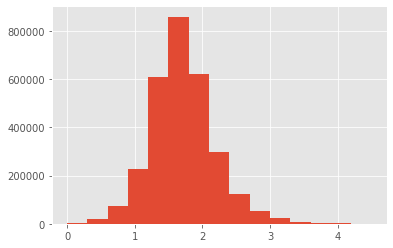

In [5]:
plt.hist(matrix[matrix <= u].flatten(), bins = 15)
plt.show()

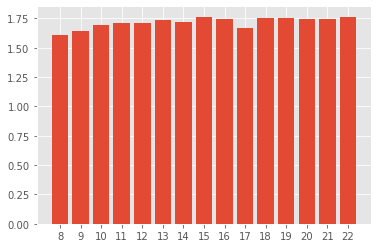

In [6]:
# Check the strength of each age group
plt.figure()
plt.style.use('ggplot')
plt.bar(HCPD.AGES, [matrix.mean(axis = 1)[accnsub[i]: accnsub[i + 1]].mean() for i in range(NAGES)])
plt.xticks(HCPD.AGES)
plt.show()

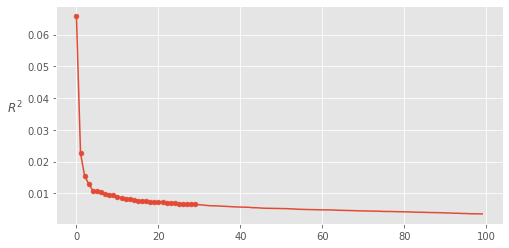

In [7]:
pca = PCA(n_components = 100)
pca.fit(matrix)

plt.figure(figsize = (8, 4))
plt.scatter(np.arange(100)[:30], pca.explained_variance_ratio_[:30], s = 24)
plt.plot(np.arange(100), pca.explained_variance_ratio_)
plt.ylabel('$R^2$', loc = 'center', rotation = 0, labelpad = 12)
plt.show()

# Time profile

In [6]:
gradients = pca.transform(matrix)
meanGrad = {}
for i, age in enumerate(maps):
    # print(f'Age: {age}, {len(gradients[accnsub[i]: accnsub[i + 1]])} maps included.')
    meanGrad[age] = gradients[accnsub[i]: accnsub[i + 1]].mean(axis = 0)

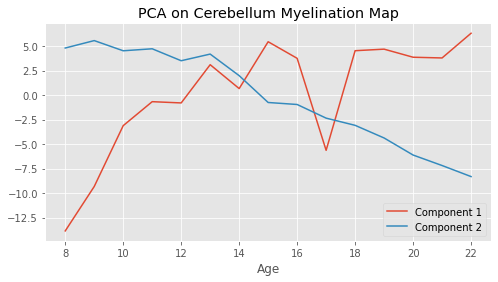

In [89]:
plt.figure(figsize = (8, 4))
plt.plot(HCPD.AGES, [grad[0] for grad in meanGrad.values()])
plt.plot(HCPD.AGES, [grad[1] for grad in meanGrad.values()])
plt.xlabel('Age')
plt.legend(['Component 1', 'Component 2'])
plt.title('PCA on Cerebellum Myelination Map')
plt.show()

# Spatial map

In [46]:
n_keep = 5
w = pca.components_.T[:, :n_keep]
output = HCPD.normalize(w, 1, 2).T

In [63]:
map1 = HCPD.getNibabelObj(HCPD.invertCerebellumMap(output[0], normals))
map2 = HCPD.getNibabelObj(HCPD.invertCerebellumMap(output[1], normals))

HCPD.nibabel.save(map1, os.path.join(DATA_DIR, 'map1.tmp.nii'))
HCPD.nibabel.save(map2, os.path.join(DATA_DIR, 'map2.tmp.nii'))

# Further Analysis with New Strategy

## Analysis procedure

1. 2IQR for each subject, set to nan, and mean value of the particular feature later

2. PCA

3. Extracting top-n components, averaged within each age group

In [42]:
# n_sub * n_voxel
maps = HCPD.setOutliersAsNan(maps)
matrix = np.row_stack(maps.values())

In [43]:
# Work through each feature, and set nan to mean
n_nan = []
for i in range(matrix.shape[1]):
    feature = matrix[:, i]
    fmean = np.nanmean(feature)
    indices = np.where(np.isnan(feature))
    n_nan.append(np.sum(np.isnan(feature)))
    matrix[indices, i] = fmean

print(stats.describe(n_nan))

DescribeResult(nobs=17853, minmax=(0, 179), mean=3.980395451744805, variance=109.25639359220872, skewness=5.399863985533173, kurtosis=45.97650023066396)


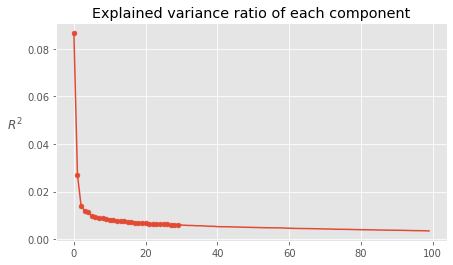

In [52]:
pca = PCA(n_components = 100)
pca.fit(matrix)

plt.figure(figsize = (7, 4))
plt.scatter(np.arange(100)[:30], pca.explained_variance_ratio_[:30], s = 24)
plt.plot(np.arange(100), pca.explained_variance_ratio_)
plt.ylabel('$R^2$', loc = 'center', rotation = 0, labelpad = 12)
plt.title('Explained variance ratio of each component')
plt.show()

# Time profile

In [45]:
gradients = pca.transform(matrix)
mean_grad = {}
for i, age in enumerate(maps):
    mean_grad[age] = gradients[accnsub[i]: accnsub[i + 1]].mean(axis = 0)

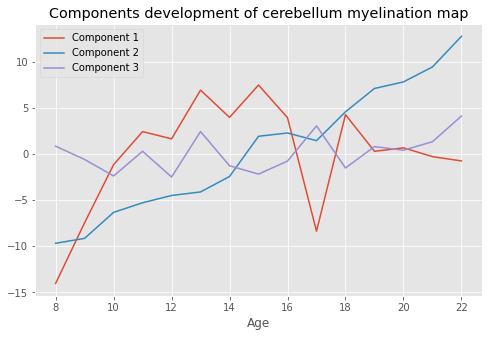

In [54]:
n_keep = 3
plt.figure(figsize = (8, 5))
for i in range(n_keep):
    plt.plot(HCPD.AGES, [grad[i] for grad in mean_grad.values()])
plt.xlabel('Age')
plt.legend([f'Component {i}' for i in range(1, n_keep + 1)])
plt.title('Components development of cerebellum myelination map')
plt.show()

# Spatial map

In [55]:
n_keep = 5
w = pca.components_.T[:, :n_keep]
output = HCPD.normalize(w, 1, 2).T

In [56]:
for i in range(n_keep):
    spatial_map = HCPD.getNibabelObj(HCPD.invertCerebellumMap(output[i]))
    HCPD.nibabel.save(spatial_map, os.path.join(DATA_DIR, f'CB-Spatial-Map-{i+1}.nii'))